## Compare Prev Violation & Psytrack

> Written by Jess Breda September 2023

For this notebook, I am writing based on updated and debugged macro search now that I am no longer accidentally fitting to all animals at once

The goals for this NB are

1. Write a flexible design matrix generator for either prev_violation (given animal_id, best tau) or psytrack classic regressors.

2. Iterate over sigmas, models and fit/test for each animal

3. Compare to a "null" model in bits/trial space.

In [2]:
import pathlib
import platform
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_context("talk")
import pathlib
import platform
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

sns.set_context("talk")

from sklearn.model_selection import train_test_split

from generate_design_matrix import ExpFilter
from get_rat_data import *
from multiclass_logistic_regression import MultiClassLogisticRegression
MODE = "local"

# settings
%load_ext autoreload
%autoreload 2

In [3]:
class DesignMatrixGeneratorCompareClassicViolation:
    def __init__(self, animal_id, verbose=True):
        self.animal_id = animal_id
        self.verbose = verbose

    @staticmethod
    def normalize_column(col):
        return (col - col.mean()) / col.std()

    def generate_design_matrix(
        self,
        df,
        feature_mode,
        tau,
        return_labels=True,
        drop_session_column=False,
    ):
        """
        Function to generate flexibledesign matrix given a dataframe
        with violations tracked. In this case "base" means using the
        same regressors as Nick Roy did in Psytrack, but adjusted to
        take into account 3 choice options (L,R, Violation).

        here, we are adding prev_violation fileted given a specific
        tau for each animal that was previously searched

        N = number of trials
        D = number of features
        C = number of classes, in this case 3 (L, R, Violation)

        params
        ------
        df : pd.DataFrame
            dataframe with columns `s_a` `s_b` `session`, `violation`
            `correct_side` and `choice`, likely generated by
            get_rat_viol_data()
        tau : float
            tau for exponential filter for prev_violation column
        feature_mode : str
            model to use for generating design matrix either
            "basic" or "violation" or "violation_filtered"
        return_label : bool (default = True)
            whether to return one-hot encoded choice labels
        drop_session_column : bool (default = False)
            whether to drop 'session' column. should be set to
            false if doing session based train/test split
            following design matrix generation

        returns
        -------
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with regressors for s_a, s_b,
            prev sound avg, correct side and choice info,
            normalized to standard normal with bias column added
        Y : np.ndarray, shape (N, C), where C = 3 if return_labels=True
            one-hot encoded choice labels for each trial as left,
            right or violation
        """
        # Initialize
        X = pd.DataFrame()
        stim_cols = ["s_a", "s_b"]
        X["session"] = df.session

        # Masks- if first trial in a session and/or previous trial
        # was a violation, "prev" variables get set to 0
        session_boundaries_mask = df["session"].diff() == 0
        X["prev_violation"] = (
            df["violation"].shift() * session_boundaries_mask
        ).fillna(0)
        prev_violation_mask = X["prev_violation"] == 0

        # # Violation Exp Filter
        if feature_mode == "violation_filtered":
            self.exp_filter = ExpFilter(
                tau=tau, verbose=self.verbose, column="prev_violation"
            )
            self.exp_filter.apply_filter_to_dataframe(X)
            X.drop(columns=["prev_violation"], inplace=True)

        # Stimuli (s_a, s_b) get normalized
        for col in stim_cols:
            X[stim_cols] = self.normalize_column(df[stim_cols])

        # Average previous stimulus (s_a, s_b) loudness
        X["prev_sound_avg"] = df[stim_cols].shift().mean(axis=1)
        X["prev_sound_avg"] = self.normalize_column(X["prev_sound_avg"])
        X["prev_sound_avg"] *= session_boundaries_mask * prev_violation_mask

        # Prev correct side (L, R) (0, 1) -> (-1, 1),
        X["prev_correct"] = (
            df.correct_side.replace({0: -1}).astype(int).shift()
            * session_boundaries_mask
            * prev_violation_mask
        )

        # prev choice regressors (L, R, V) (0, 1, Nan) -> (-1, 1, 0),
        X["prev_choice"] = (
            df.choice.replace({0: -1}).fillna(0).astype(int).shift()
            * session_boundaries_mask
        )

        if feature_mode == "base":
            X.drop(columns=["prev_violation"], inplace=True)

        X.fillna(0, inplace=True)  # remove nan from shift()
        X.insert(0, "bias", 1)  # add bias column

        if drop_session_column:
            X.drop(columns=["session"], inplace=True)

        if return_labels:
            Y = self.one_hot_encode_labels(df)
            return X, Y
        else:
            return X

    @staticmethod
    def one_hot_encode_labels(df):
        """
        Function to one-hot encode choice labels for each trial as
        left, right or violation (C = 3)

        params
        ------
        df : pd.DataFrame
            dataframe with columns `choice` likely generated by
            get_rat_viol_data()

        returns
        -------
        Y : np.ndarray, shape (N, C), where C = 3
            one-hot encoded choice labels for each trial as left,
            right or violation
        """

        Y = pd.get_dummies(df["choice"], "choice", dummy_na=True).to_numpy(copy=True)
        return Y

    def get_train_test_sessions(self, df, test_size, random_state=45):
        """
        This function will return a list of sessions to use for training
        and testing respectively. To apply, see function
        see apply_session_train_test_split()


        Parameters:
        -----------
        df : pd.DataFrame
            dataframe with `sessions` column
        test_size : float
            Proportion of data to use for test set
        """
        unique_sessions = df["session"].unique()
        train_sessions, test_sessions = train_test_split(
            unique_sessions, test_size=test_size, random_state=random_state
        )

        self.train_sessions = train_sessions
        self.test_sessions = test_sessions
        self.random_state = random_state
        self.test_size = test_size

    def apply_session_train_test_split(self, X, Y):
        """
        train_sessions = np.array
            sessions for the
        test_values = np.array indices for the test values

        """
        # check if train/test sessions have been set
        if not hasattr(self, "train_sessions"):
            raise ValueError(
                "train_sessions and test_sessions have not been set. "
                "Please run get_train_test_sessions() first."
            )

        # Filter rows based on session values for X
        X_train = X[X["session"].isin(self.train_sessions)].copy()
        X_test = X[X["session"].isin(self.test_sessions)].copy()

        # Filter rows based on session values for Y
        # Assuming the index of Y corresponds to that of X
        Y_train = Y[X["session"].isin(self.train_sessions).values]
        Y_test = Y[X["session"].isin(self.test_sessions).values]

        X_train.drop(columns=["session"], inplace=True)
        X_test.drop(columns=["session"], inplace=True)

        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test

        return X_train, X_test, Y_train, Y_test

    def fit_null_model(self, animal_df):
        """
        Fits a null model and returns the log likelihood.

        Parameters:
        animal_df: DataFrame with choice and session data.

        Returns:
        float:
        """
        # Convert nan (violation) -> 2, L = 0, R =1
        choice = animal_df.choice.fillna(2)
        test_labels = choice[animal_df["session"].isin(self.test_sessions).values]

        # Count occurrences of each label
        label_counts = Counter(test_labels)

        # Calculate the total number of observations
        total_count = len(test_labels)

        # Calculate observed probabilities
        probabilities = {
            label: count / total_count for label, count in label_counts.items()
        }

        # Calculate the log-likelihood based on the observed probabilities
        log_likelihood = 0
        for label, prob in probabilities.items():
            log_likelihood += label_counts[label] * np.log(prob)
        return {
            "nll": -log_likelihood,
            "p_left": probabilities[0],
            "n_left": label_counts[0],
            "p_right": probabilities[1],
            "n_right": label_counts[1],
            "p_viol": probabilities[2],
            "n_viol": label_counts[2],
            "n_test_trials": total_count,
            "n_train_trials": len(animal_df) - total_count,
        }

    def store_null_info(self, animal_df):
        null_model = self.fit_null_model(animal_df)

        animal_info_df = pd.DataFrame(
            {
                "animal_id": [self.animal_id],
                "nll": [null_model["nll"]],
                "test_size": [self.test_size],
                "random_state": [self.random_state],
                "p_violation": [null_model["p_viol"]],
                "n_violation": [null_model["n_viol"]],
                "p_left": [null_model["p_left"]],
                "n_left": [null_model["n_left"]],
                "p_right": [null_model["p_right"]],
                "n_right": [null_model["n_right"]],
                "n_test_trials": [null_model["n_test_trials"]],
                "test_sessions": [self.test_sessions],
                "n_train_trials": [null_model["n_train_trials"]],
                "train_sessions": [self.train_sessions],
            }
        )
        # will be concat in experiment loop
        return animal_info_df

In [4]:
animal_id = "W065"
df = get_rat_viol_data(animal_id)
dmg = DesignMatrixGeneratorCompareClassicViolation(animal_id=animal_id)
dmg.get_train_test_sessions(df, test_size=0.2, random_state=45)
dmg.store_null_info(df)

returning viol data for W065


,animal_id,nll,test_size,random_state,p_violation,n_violation,p_left,n_left,p_right,n_right,n_test_trials,test_sessions,n_train_trials,train_sessions
0,W065,10886.977495,0.2,45,0.248734,2505,0.359944,3625,0.391322,3941,10071,"[46, 73, 41, 59, 26, 14, 154, 81, 4, 45, 135, ...",40034,"[98, 175, 139, 68, 176, 117, 136, 30, 62, 84, ..."


In [5]:
class SigmaSearchCompareClassicViolation:
    def __init__(self, params):
        self.animals = params["animals"]
        self.sigmas = params["sigmas"]
        self.model_names = params["model_names"]
        self.random_state = params["random_state"]
        self.test_size = params["test_size"]
        self.taus = self.get_taus()
        self.df = get_rat_viol_data(animal_ids=self.animals)
        self.stored_fits = []
        self.null_models = []

        if self.animals is None:
            self.animals = self.df.animal_id.unique()
        self.n_animals = len(self.animals)

    def run(self):
        for animal in self.animals:
            print(f"\n\n !!!!! evaluating animal {animal} !!!!!\n\n")
            if self.df.animal_id.nunique() > 1:
                # Load in data for specific animal
                animal_df = self.df.query("animal_id == @animal and training_stage > 2")
            else:
                animal_df = self.df.query("training_stage > 2")

            # Create a DesignMatrixGenerator object & get train/test sessions for animal
            dmg = DesignMatrixGeneratorCompareClassicViolation(
                verbose=False, animal_id=animal
            )
            dmg.get_train_test_sessions(
                animal_df, test_size=self.test_size, random_state=self.random_state
            )

            # store train/test info and null fit
            self.null_models.append(dmg.store_null_info(animal_df))

            # get tau for this animal
            tau = self.taus.query("animal_id == @animal")["tau"].values[0]

            # Iterate over sigma/tau combinations
            for sigma in self.sigmas:
                for model_name in self.model_names:
                    # Generate design matrix & create train/test splits
                    X, Y = dmg.generate_design_matrix(
                        animal_df,
                        tau=tau,
                        feature_mode=model_name,
                        return_labels=True,
                    )
                    print(
                        f"model : {model_name}, sigma: {sigma}, tau: {tau}, size of X: {X.shape}, Y: {Y.shape}"
                    )
                    (
                        X_train,
                        X_test,
                        Y_train,
                        Y_test,
                    ) = dmg.apply_session_train_test_split(X, Y)

                    # Fit model & evaluate
                    model = MultiClassLogisticRegression(sigma=sigma)
                    W_fit = model.fit(X_train, Y_train)
                    nll = model.eval(X_test, Y_test)

                    # Store model_fits
                    self.store(
                        animal,
                        model_name,
                        nll,
                        sigma,
                        tau,
                        W_fit,
                        dmg,
                    )

        self.model_fits = pd.concat(self.stored_fits, ignore_index=True)
        self.null_fits = pd.concat(self.null_models, ignore_index=True)
        return self.model_fits, self.null_fits

    def store(self, animal, model_name, nll, sigma, tau, W_fit, dmg):
        # Create a DataFrame for this iteration
        iter_df = pd.DataFrame(
            {
                "animal_id": [animal],
                "model_name": [model_name],
                "nll": [nll],
                "sigma": [sigma],
                "tau": [tau],
                "features": [list(dmg.X_test.columns)],
                "weights": [list(W_fit)],  # Convert numpy array to list
            }
        )
        # Append to the list of stored fits
        self.stored_fits.append(iter_df)

    ## WRANGLING ##

    def get_taus(self):
        """Load df with tau values for each animal
        that were found in macro sweep"""
        taus_df = pd.read_csv(
            "/Users/jessbreda/Desktop/github/animal-learning/data/results/prev_violation_tau.csv"
        )
        return taus_df

    def find_best_fit(self, group="model_name"):
        # if group is model name, will find the best sigma for
        # each tau tested.
        # if group is sigma, will find the best model name for
        # each sigma tested.

        best_fit_dfs = []

        for animal_id, sub_df in self.model_fits.groupby(["animal_id"]):
            best_idx = sub_df.groupby(group)["nll"].idxmin()
            best_fit_df = sub_df.loc[best_idx][
                ["animal_id", "model_name", "sigma", "tau", "nll"]
            ]
            best_fit_dfs.append(best_fit_df)

        return pd.concat(best_fit_dfs, ignore_index=True)

    def query_min_nll(self, animal_id, model_name):
        """
        Query the row with the minimum NLL for a given animal_id and model_name
        """
        query = self.model_fits.query(
            "animal_id == @animal_id and model_name == @model_name"
        ).sort_values(by="nll", ascending=True)

        return query.iloc[0]

    def compute_bits_per_trial_df(self):
        """
        Wrapper function to compute the number of bits per trial
        for each animal and model relative to the null model
        and return a dataframe with the results
        """
        combined_df = self._merge_null_and_fit_model_dfs()

        bits_per_trial_df = (
            combined_df.groupby("animal_id")
            .apply(self._calculate_bits_per_trial)
            .reset_index(drop=True)
        )

        self.bits_per_trial_df = bits_per_trial_df
        return bits_per_trial_df

    def _merge_null_and_fit_model_dfs(self):
        """
        Merge the null and model fit dataframes together
        with respect to negative log-like
        """

        # clean up dfs for concating
        self.null_fits["model_name"] = "null"
        best_fits = self.find_best_fit(
            group=["animal_id", "model_name"]
        )  # find best sigma for each animal, model

        # concat nll for null and fit models
        combined_df = pd.concat(
            [
                self.null_fits[["animal_id", "nll", "model_name"]],
                best_fits[["animal_id", "nll", "model_name"]],
            ]
        )

        # add in number of test trials for each animal
        combined_df = pd.merge(
            combined_df,
            self.null_fits[["animal_id", "n_test_trials"]],
            on="animal_id",
            how="left",
        )

        combined_df = pd.merge(
            combined_df, best_fits[["animal_id", "tau"]], on="animal_id", how="left"
        )

        # add in log-like (for easier bit calculation)
        combined_df["log_like"] = combined_df["nll"] * -1

        return combined_df

    def _calculate_bits_per_trial(self, group):
        """
        Calculate the number of bits per trial relative for each model
        relative to the null model (L_0) for each animal (group)

        bit/trial = (log model - log null model) / (n_test_trials * log(2))

        params
        ------
        group : pd.DataFrame
            groupby object with columns `animal_id`, `model_name`,
            `n_test_trials` and `ll` (log-likelihood)
            grouped by animal_id
        """
        bits_per_trial = []

        n_test_trials = group["n_test_trials"].iloc[
            0
        ]  # assumes each animal has same test size

        null_ll = group.query("model_name == 'null'")["log_like"].iloc[0]

        for _, row in group.iterrows():
            if row["model_name"] == "null":
                bits_per_trial.append((null_ll) / (n_test_trials * np.log(2)))
            else:
                bits_per_trial.append(
                    (row["log_like"] - null_ll) / (n_test_trials * np.log(2))
                )

        group["bits_per_trial"] = bits_per_trial
        return group

    ## PLOTTING ##

    def plot_nll_over_sigmas_by_animal(self, df=None):
        if df is None:
            df = self.find_best_fit(group="sigma")

        n_animals = df.animal_id.nunique()
        fig, ax = plt.subplots(
            n_animals, 1, figsize=(15, 5 * n_animals), sharex=True, sharey=True
        )

        df["is_min"] = df.groupby("animal_id")["nll"].transform(lambda x: x == x.min())

        if n_animals == 1:
            ax = [ax]

        for idx, (animal_id, sub_df) in enumerate(df.groupby("animal_id")):
            plt.xticks(rotation=90)

            current_ax = ax[idx] if n_animals > 1 else ax[0]

            sns.scatterplot(
                x="sigma",
                y="nll",
                data=sub_df,
                ax=current_ax,
                hue="is_min",
                palette=["grey", "red"],
            )

            # aesthetics
            plt.xticks(rotation=90)
            sns.despine()
            current_ax.legend().remove()
            current_ax.set(
                ylabel="Test NLL",
                title=f"Animal {animal_id}",
            )
            # if on the last plot, add the x-axis label
            if idx == n_animals - 1:
                current_ax.set(xlabel="Sigma")
            else:
                current_ax.set(xlabel="")

        return None

    def plot_class_weights(self, animal_id, model_name):
        """
        Wrapper function to plot class weights for a given animal and model
        """
        row = self.query_min_nll(animal_id, model_name)
        self._plot_class_weights(
            row["features"], np.array(row["weights"]), title=f"{animal_id} {model_name}"
        )

    def _plot_class_weights(self, feature_names, W_fit, title=""):
        """
        Internal function to plot the weights for each feature and class as bar charts.
        """
        D, C = W_fit.shape
        classes = ["L", "R", "V"]

        weight_data = [
            {"Weight": W_fit[d, c], "Feature": feature_names[d], "Class": classes[c]}
            for c in range(C)
            for d in range(D)
        ]
        df_weights = pd.DataFrame(weight_data)

        fig, ax = plt.subplots(figsize=(15, 6))
        ax.axhline(y=0, color="black")
        sns.barplot(x="Feature", y="Weight", hue="Class", data=df_weights, ax=ax)
        plt.xticks(rotation=45)
        plt.legend(loc="upper left")
        plt.title(title)

    def plot_model_comparison(
        self, type="point", hue=None, ax=None, ylim=None, **kwargs
    ):
        """
        Plot the model comparison for each animal
        """

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 5))

        if not hasattr(self, "bits_per_trial_df"):
            self.compute_bits_per_trial_df()

        if type == "point":
            sns.pointplot(
                data=self.bits_per_trial_df.query("model_name != 'null'"),
                x="model_name",
                y="bits_per_trial",
                hue=hue,
                ax=ax,
                **kwargs,
            )
        elif type == "bar":
            sns.barplot(
                data=self.bits_per_trial_df.query("model_name != 'null'"),
                x="model_name",
                y="bits_per_trial",
                hue=hue,
                ax=ax,
                **kwargs,
            )

        if hue == "animal_id":
            ax.legend().remove()
        if hue == "tau":
            ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
        plt.xlabel("Model")
        plt.ylabel("Bits/Trial")

        if ylim is not None:
            ax.set(ylim=ylim)

        return None

In [6]:
params = {
    "animals": None,
    "sigmas": [0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
    "model_names": ["base", "violation", "violation_filtered"],
    "random_state": 47,
    "test_size": 0.25,
}

# params = {
#     "animals": ["W065", "W078"],
#     "sigmas": [2, 4],  # [0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
#     "model_names": ["base", "violation", "violation_filtered"],
#     "random_state": 47,
#     "test_size": 0.25,
# }
experiment = SigmaSearchCompareClassicViolation(params)

returning viol dataset for all animals


In [7]:
model_fits, null_fits = experiment.run()



 !!!!! evaluating animal W051 !!!!!


model : base, sigma: 0.13, tau: 6, size of X: (55433, 7), Y: (55433, 3)
Optimization terminated successfully.
         Current function value: 39058.881852
         Iterations: 22
         Function evaluations: 37
         Gradient evaluations: 37
model : violation, sigma: 0.13, tau: 6, size of X: (55433, 8), Y: (55433, 3)
         Current function value: 38429.109681
         Iterations: 23
         Function evaluations: 79
         Gradient evaluations: 67
model : violation_filtered, sigma: 0.13, tau: 6, size of X: (55433, 8), Y: (55433, 3)
         Current function value: 38136.723851
         Iterations: 24
         Function evaluations: 71
         Gradient evaluations: 60
model : base, sigma: 0.25, tau: 6, size of X: (55433, 7), Y: (55433, 3)
Optimization terminated successfully.
         Current function value: 39041.492792
         Iterations: 22
         Function evaluations: 37
         Gradient evaluations: 37
model : violation, sigma:

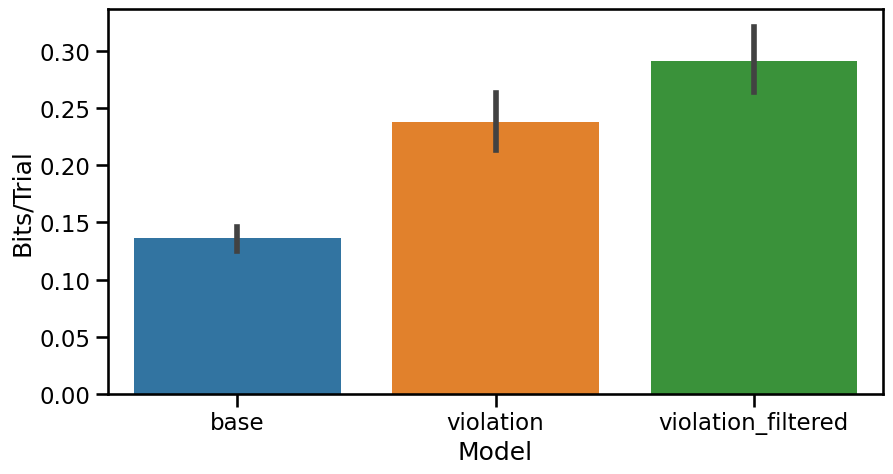

In [8]:
experiment.plot_model_comparison(type="bar")

(array([0, 1, 2]),
 [Text(0, 0, 'base'),
  Text(1, 0, 'violation'),
  Text(2, 0, 'violation_filtered')])

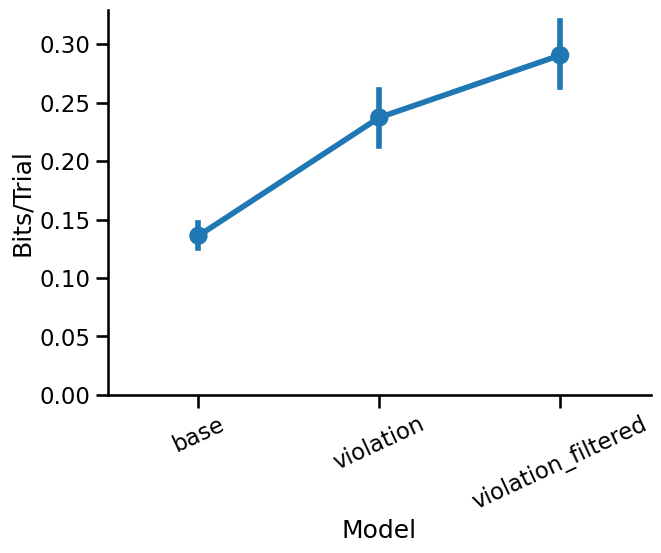

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))
experiment.plot_model_comparison(type="point", ax=ax, ylim=(0, None))
sns.despine()
plt.xticks(rotation=25)

In [15]:
x = experiment.compute_bits_per_trial_df().to_csv(
    "compare_prev_viol_psytrack_bits_per_trial.csv", index=False
)

# x.to_csv("compare_prev_viol_psytrack_bits_per_trial.csv", index=False)

In [10]:
experiment.null_fits["model_name"] = "null"
best_fits = experiment.find_best_fit(
    group=["animal_id", "model_name"]
)  # find best sigma for each animal, model

# concat nll for null and fit models
combined_df = pd.concat(
    [
        experiment.null_fits[["animal_id", "nll", "model_name"]],
        best_fits[["animal_id", "nll", "model_name"]],
    ]
)

# add in number of test trials for each animal
combined_df = pd.merge(
    combined_df,
    experiment.null_fits[["animal_id", "n_test_trials"]],
    on="animal_id",
    how="left",
)

combined_df

,animal_id,nll,model_name,n_test_trials
0,W051,14808.888189,null,14534
1,W060,10647.188847,null,10436
2,W061,8220.928368,null,7497
3,W062,6715.445475,null,6120
4,W065,11325.328773,null,10487
...,...,...,...,...
71,W089,8763.450722,violation,10567
72,W089,8134.469232,violation_filtered,10567
73,W094,6671.668852,base,6667
74,W094,6542.349859,violation,6667


(array([0, 1, 2]),
 [Text(0, 0, 'base'),
  Text(1, 0, 'violation'),
  Text(2, 0, 'violation_filtered')])

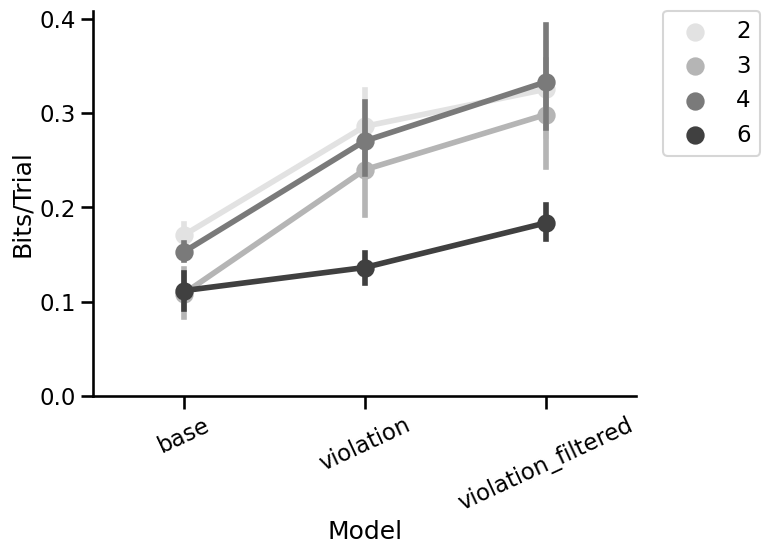

In [11]:
fig, ax = plt.subplots(figsize=(7, 5))

experiment.plot_model_comparison(
    type="point", hue="tau", palette="Greys", ax=ax, ylim=(0, None)
)
sns.despine()
plt.xticks(rotation=25)

(array([0, 1, 2]),
 [Text(0, 0, 'base'),
  Text(1, 0, 'violation'),
  Text(2, 0, 'violation_filtered')])

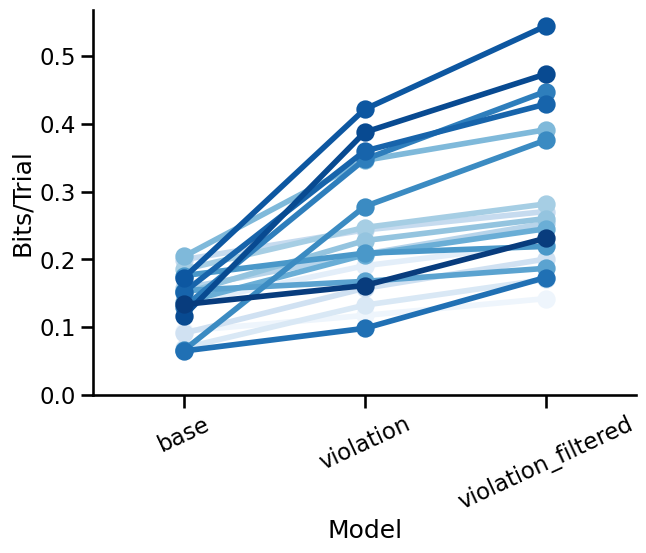

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))

experiment.plot_model_comparison(
    type="point", hue="animal_id", palette="Blues", ax=ax, ylim=(0, None)
)
sns.despine()
plt.xticks(rotation=25)

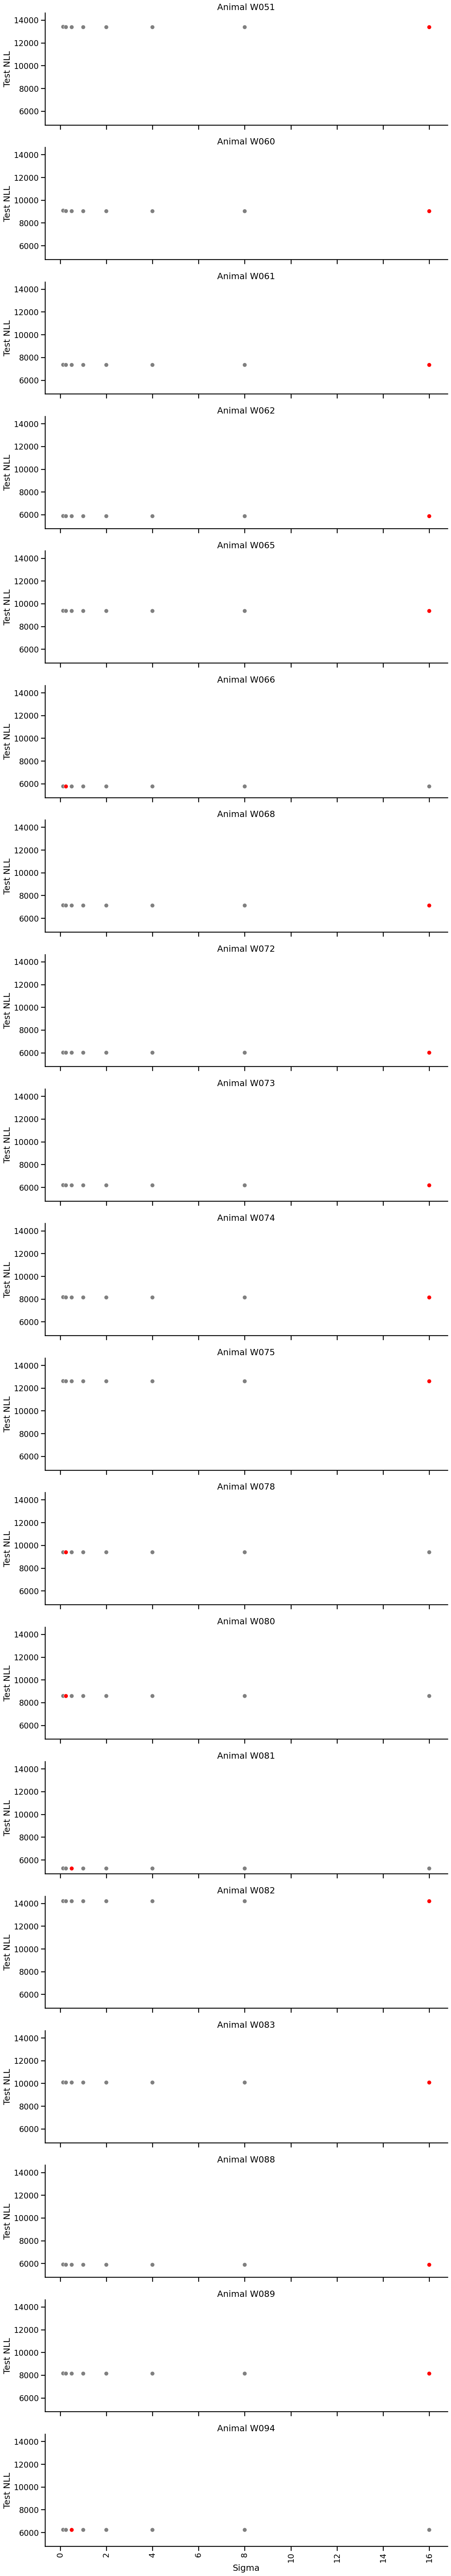

In [9]:
experiment.plot_nll_over_sigmas_by_animal()

In [17]:
experiment.find_best_fit?

Signature: experiment.find_best_fit(group='model_name')
Docstring: <no docstring>
File:      /var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_62757/1499397920.py
Type:      method

In [23]:
best_fits = experiment.find_best_fit()
best_fits

,animal_id,model_name,sigma,tau,nll
0,W051,base,16.00,6,13860.100598
1,W051,violation,16.00,6,13627.588535
2,W051,violation_filtered,16.00,6,13377.834257
3,W060,base,0.13,4,9673.801121
4,W060,violation,16.00,4,9268.344014
5,W060,violation_filtered,16.00,4,9026.235886
6,W061,base,0.13,3,7860.662413
7,W061,violation,16.00,3,7532.658282
8,W061,violation_filtered,16.00,3,7335.090216
9,W062,base,16.00,3,6329.217132


In [25]:
base_best = best_fits.query("model_name == 'base'")



,animal_id,model_name,sigma,tau,nll
0,W051,base,16.00,6,13860.100598
3,W060,base,0.13,4,9673.801121
6,W061,base,0.13,3,7860.662413
9,W062,base,16.00,3,6329.217132
12,W065,base,16.00,3,9873.549921
15,W066,base,0.13,4,6174.132152
18,W068,base,0.25,4,7646.110908
21,W072,base,16.00,2,6504.750979
24,W073,base,16.00,2,7172.421716
27,W074,base,16.00,4,8829.594393


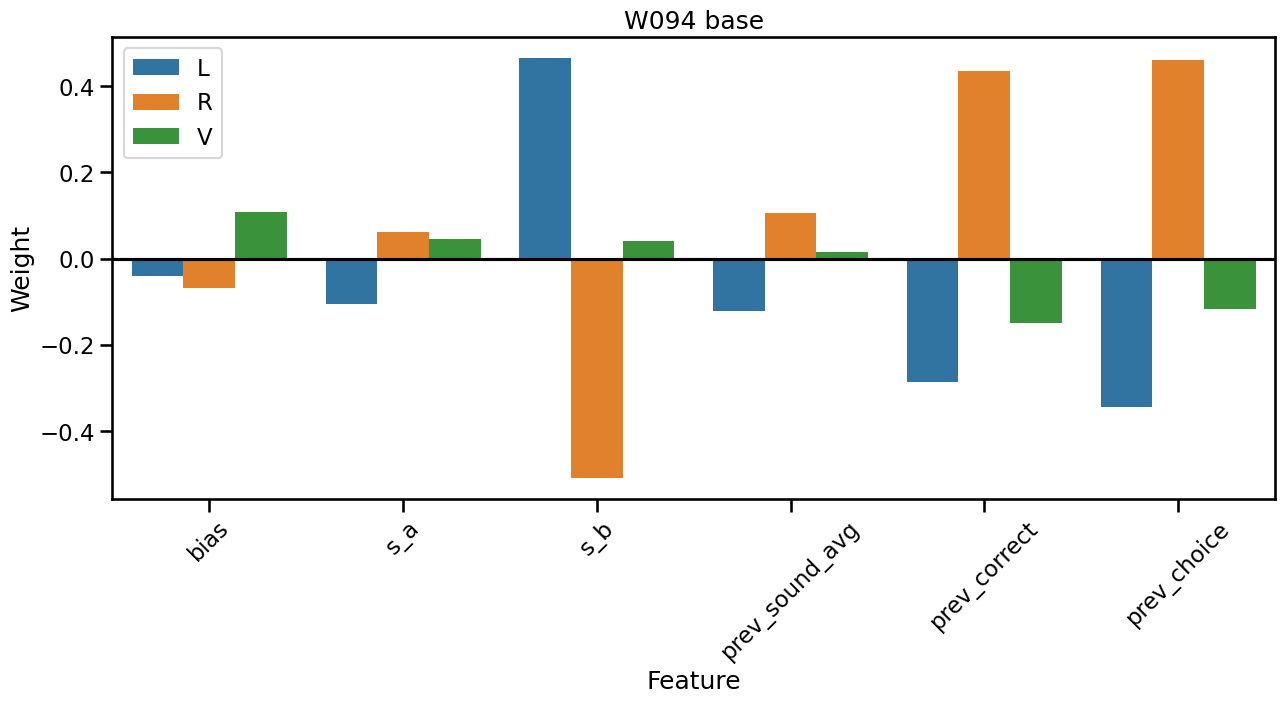

In [27]:
experiment.plot_class_weights(animal_id="W094", model_name="base")

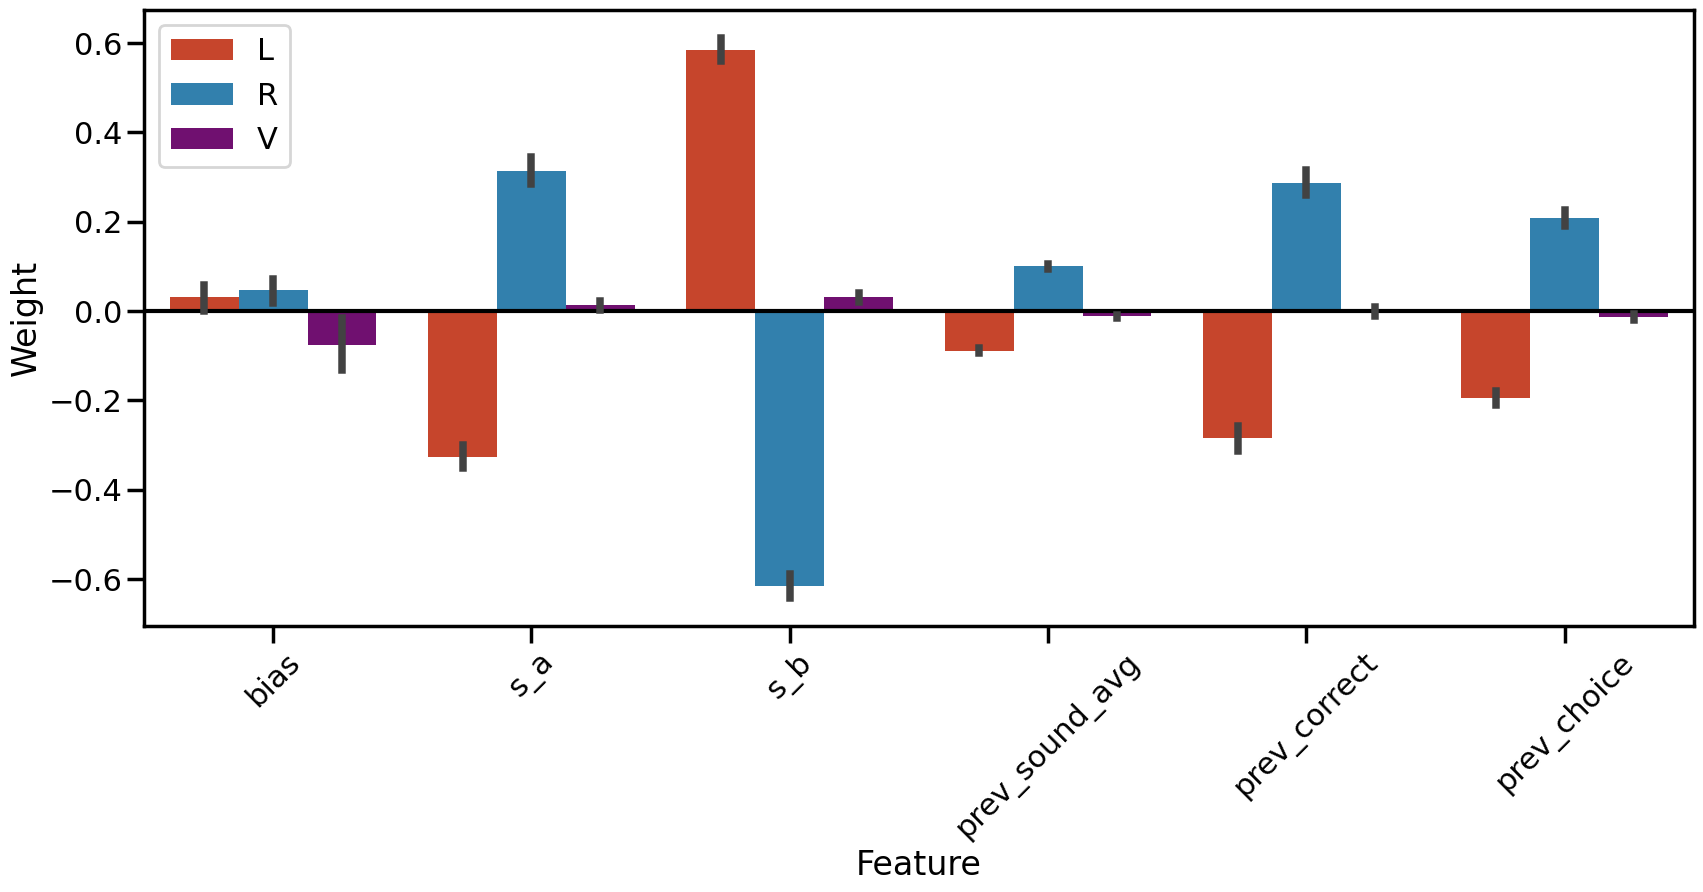

In [34]:
sns.set_context("poster")


class PlotModelWeights:
    def __init__(self, main_dataframe):
        self.main_dataframe = main_dataframe  # Assuming you store main data here

    def plot_all_class_weights(self):
        """
        Function to plot class weights for all animals and models.
        """
        # Prepare an empty DataFrame to collect data
        all_weight_data = pd.DataFrame(
            columns=["Weight", "Feature", "Class", "Animal_ID", "Model_Name"]
        )

        # Loop through all rows in the main DataFrame
        for index, row in self.main_dataframe.iterrows():
            animal_id = row["animal_id"]
            model_name = row[
                "model_name"
            ]  # Assuming MultiIndex (model_name, animal_id)
            feature_names = row["features"]
            W_fit = np.array(row["weights"])

            weight_data = self._plot_class_weights(
                feature_names, W_fit, animal_id, model_name
            )
            all_weight_data = pd.concat([all_weight_data, weight_data])

        # Plotting
        fig, ax = plt.subplots(figsize=(20, 8))
        ax.axhline(y=0, color="black")
        sns.barplot(
            x="Feature",
            y="Weight",
            hue="Class",
            palette=["#e03412", "#1d85c2", "purple"],
            data=all_weight_data,
        )
        plt.xticks(rotation=45)
        plt.legend(loc="upper left")
        plt.show()

    def _plot_class_weights(self, feature_names, W_fit, animal_id, model_name):
        """
        Internal function to prepare the DataFrame for plotting weights.
        """
        D, C = W_fit.shape
        classes = ["L", "R", "V"]

        weight_data = [
            {
                "Weight": W_fit[d, c],
                "Feature": feature_names[d],
                "Class": classes[c],
                "Animal_ID": animal_id,
                "Model_Name": model_name,
            }
            for c in range(C)
            for d in range(D)
        ]
        return pd.DataFrame(weight_data)


base = PlotModelWeights(model_fits.query("model_name == 'base'"))
base.plot_all_class_weights()

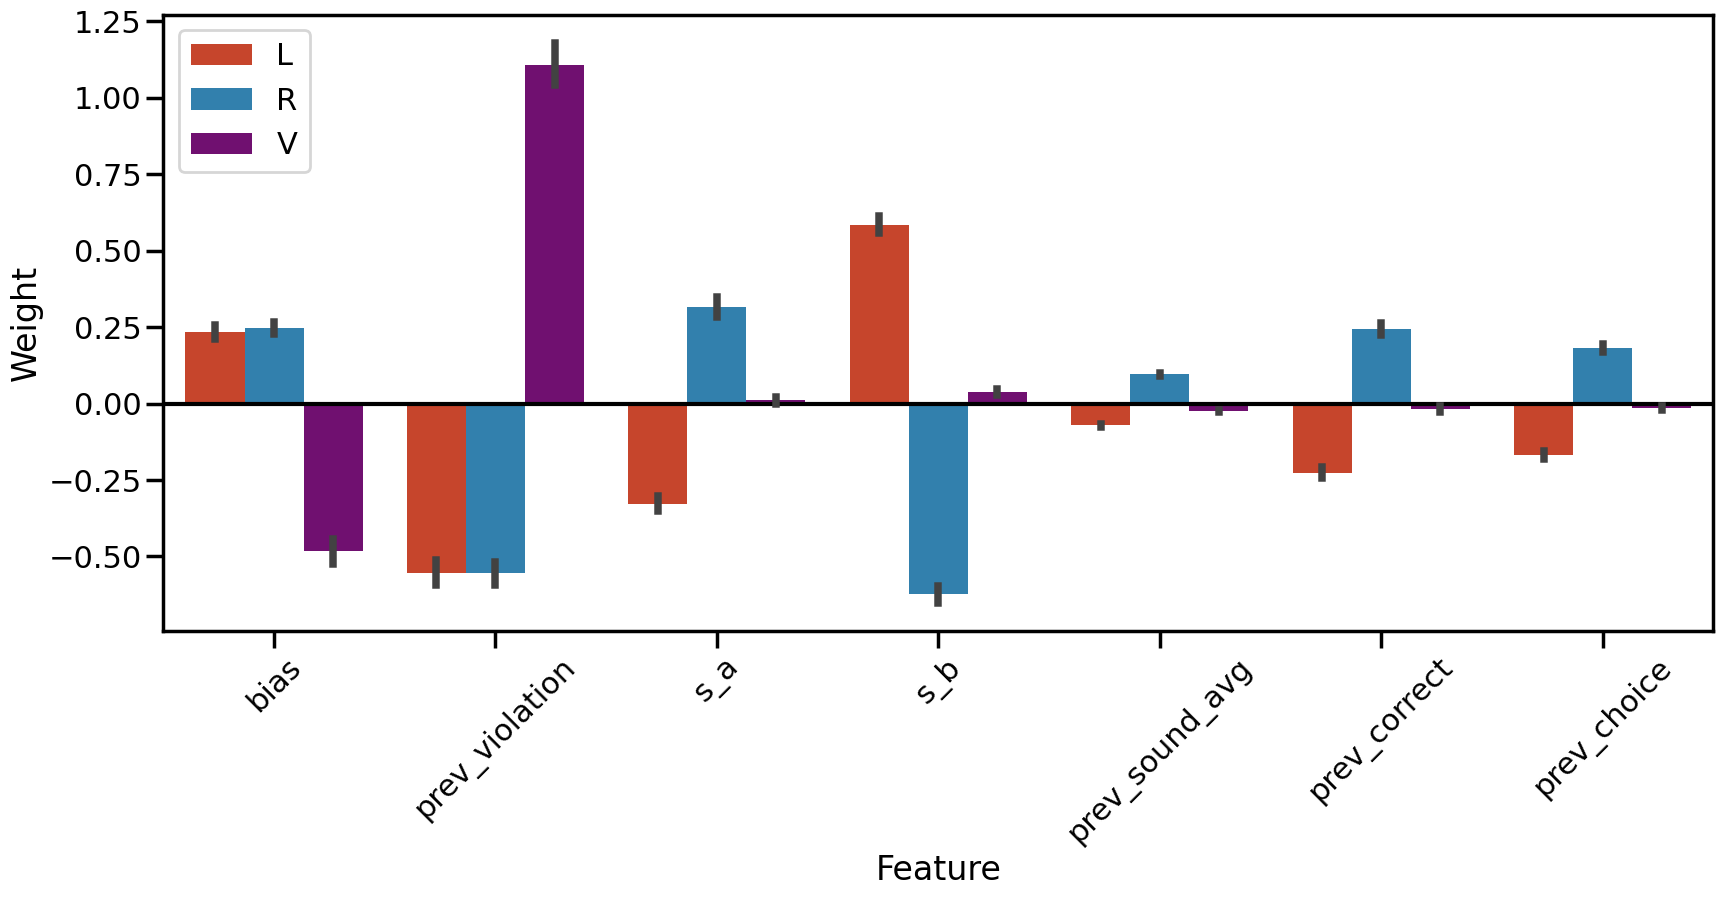

In [35]:
base = PlotModelWeights(model_fits.query("model_name == 'violation'"))
base.plot_all_class_weights()

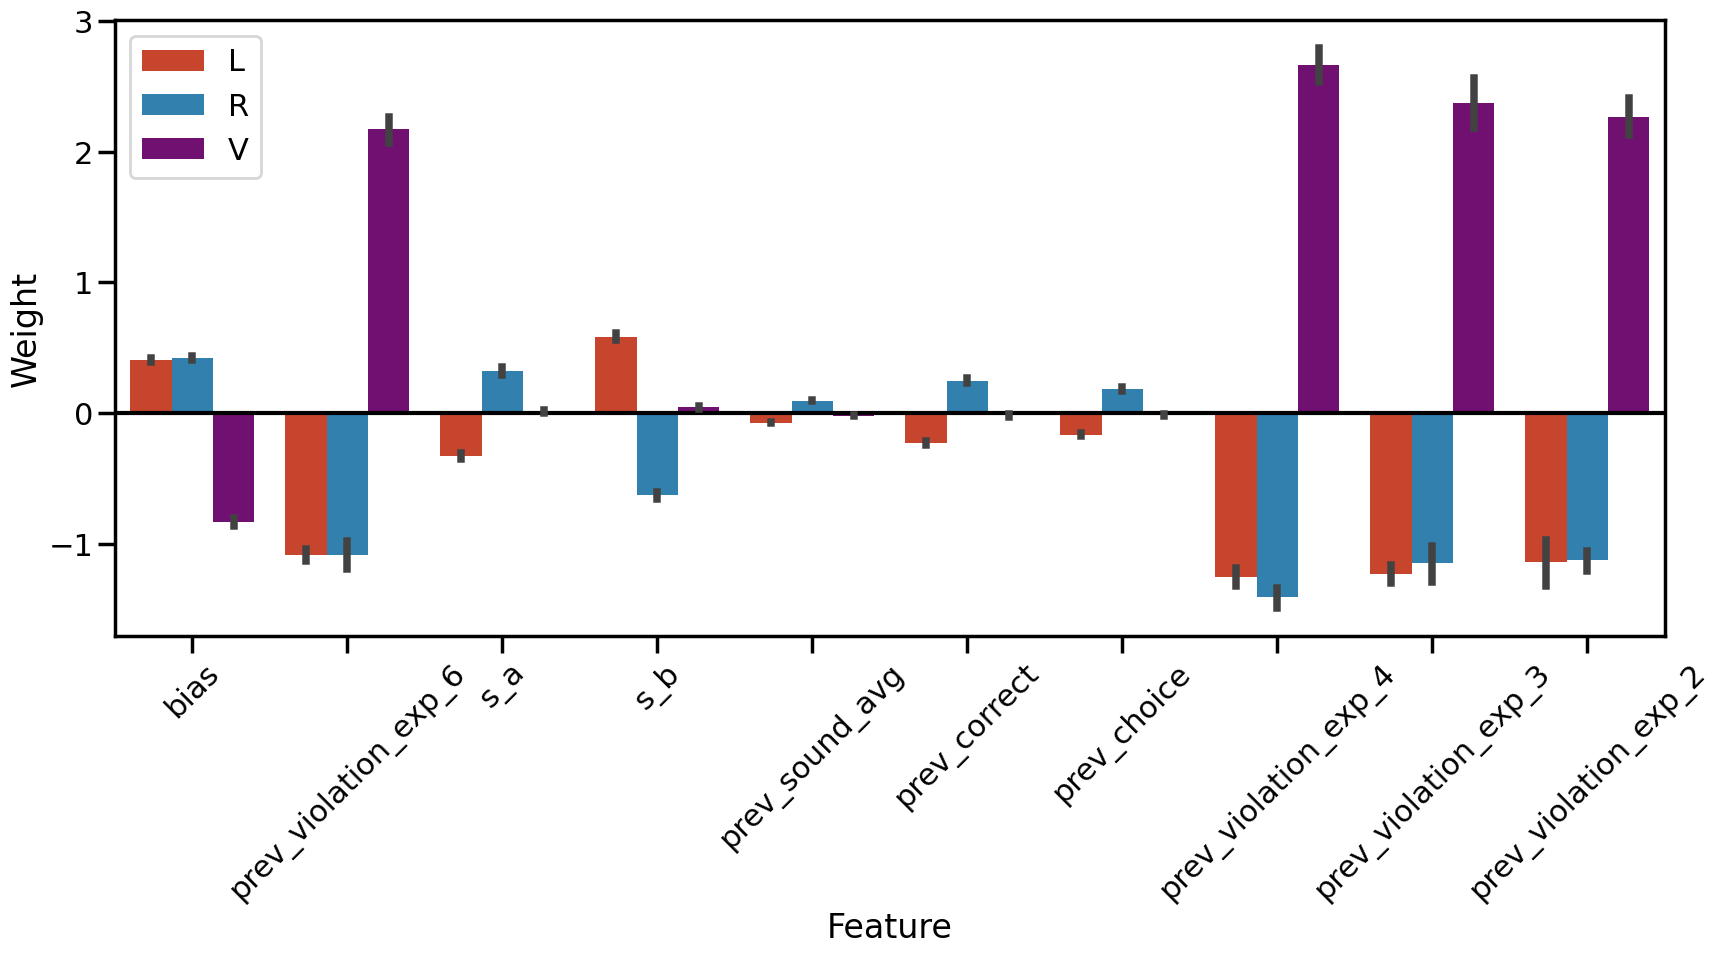

In [43]:
base = PlotModelWeights(model_fits.query("model_name == 'violation_filtered'"))
base.plot_all_class_weights()

In [57]:
test = model_fits.query("model_name == 'violation_filtered'").copy()

In [75]:
def preprocess_features(df_w_filter):
    """
    Internal method to preprocess the 'features' column.
    Replaces 'prev_violation_exp_X' with 'prev_violation_filtered'.
    """

    def replace_prev_violation(exp_list):
        return [
            "prev_violation_filtered" if "prev_violation_exp_" in feature else feature
            for feature in exp_list
        ]

    df_w_filter["features"] = df_w_filter["features"].apply(replace_prev_violation)


test = model_fits.query("model_name == 'violation_filtered'").copy()
preprocess_features(test)

In [78]:
test

,animal_id,model_name,nll,sigma,tau,features,weights
2,W051,violation_filtered,13409.430411,0.13,6,"[bias, prev_violation_filtered, s_a, s_b, prev...","[[0.46047260007475954, 0.5069155371605573, -0...."
5,W051,violation_filtered,13384.226415,0.25,6,"[bias, prev_violation_filtered, s_a, s_b, prev...","[[0.4888916634457322, 0.5465248475440213, -1.0..."
8,W051,violation_filtered,13379.172834,0.50,6,"[bias, prev_violation_filtered, s_a, s_b, prev...","[[0.4990614287761923, 0.5608173739442295, -1.0..."
11,W051,violation_filtered,13378.148982,1.00,6,"[bias, prev_violation_filtered, s_a, s_b, prev...","[[0.5018139452684494, 0.5646965612355106, -1.0..."
14,W051,violation_filtered,13377.910793,2.00,6,"[bias, prev_violation_filtered, s_a, s_b, prev...","[[0.5025165469118063, 0.5656874879666433, -1.0..."
...,...,...,...,...,...,...,...
443,W094,violation_filtered,6219.936728,1.00,6,"[bias, prev_violation_filtered, s_a, s_b, prev...","[[0.38599032125657545, 0.2865669938181222, -0...."
446,W094,violation_filtered,6220.001368,2.00,6,"[bias, prev_violation_filtered, s_a, s_b, prev...","[[0.38735894129524423, 0.28763594208972604, -0..."
449,W094,violation_filtered,6220.018803,4.00,6,"[bias, prev_violation_filtered, s_a, s_b, prev...","[[0.3877029110294061, 0.2879045197339588, -0.6..."
452,W094,violation_filtered,6220.023242,8.00,6,"[bias, prev_violation_filtered, s_a, s_b, prev...","[[0.38778901765697005, 0.2879717484558841, -0...."


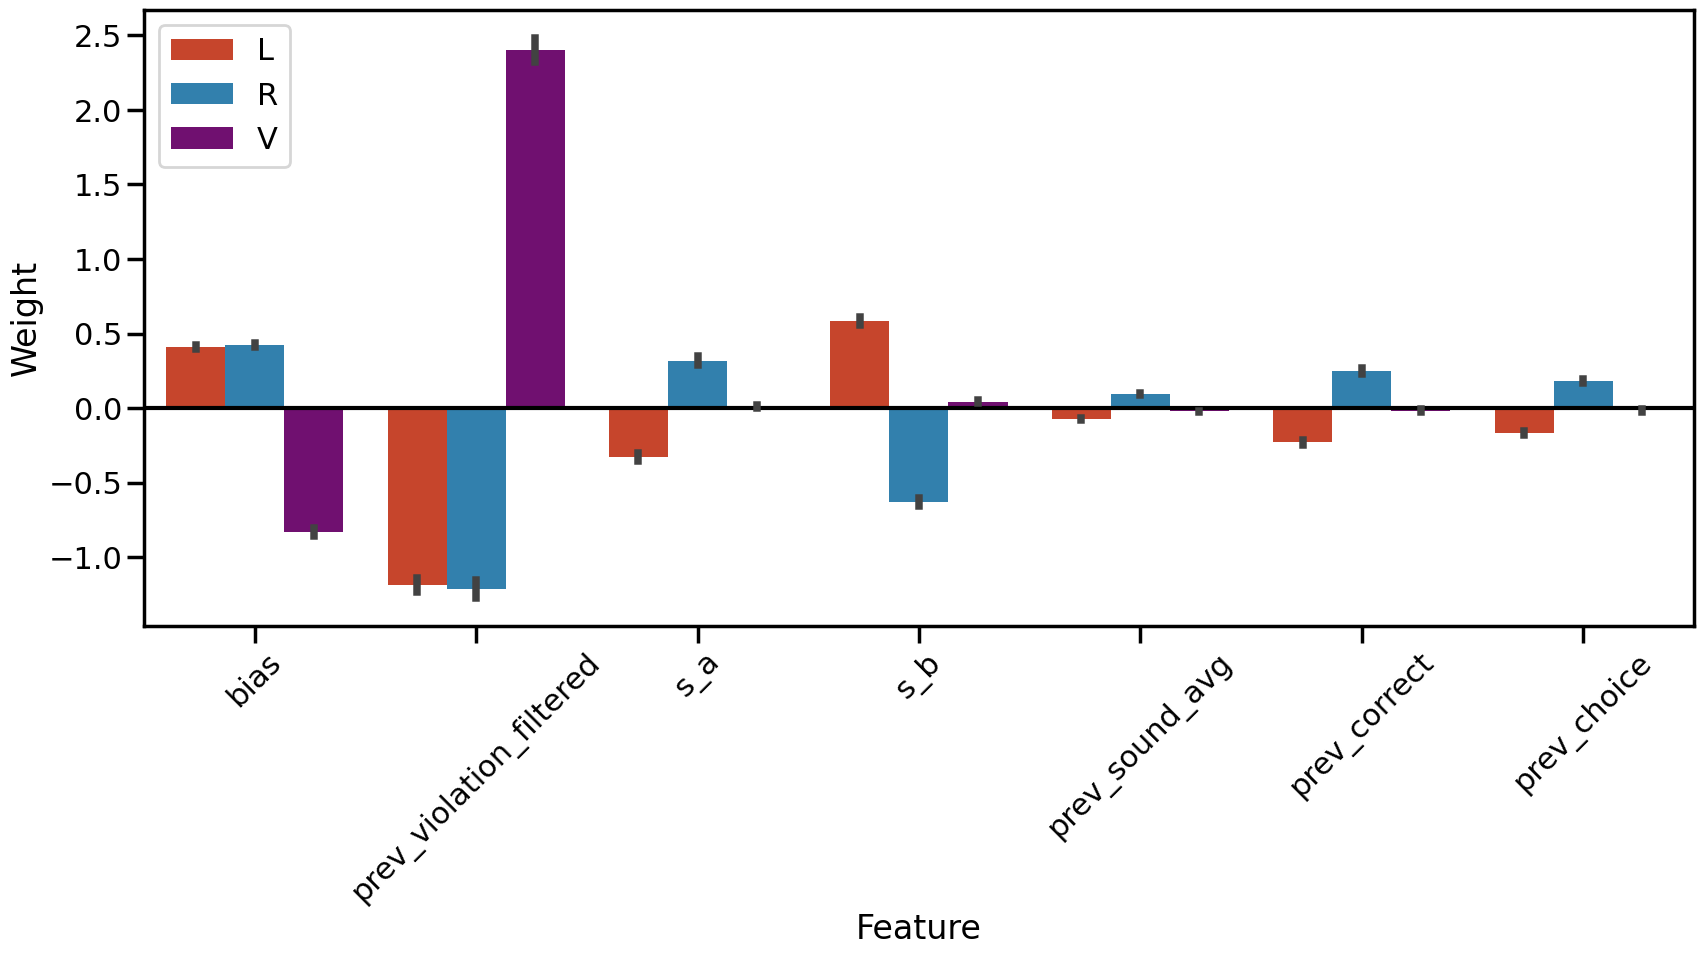

In [79]:
filtviol = PlotModelWeights(test)
filtviol.plot_all_class_weights()

In [121]:
def count_sessions(session_list):
    return len(session_list)


# Apply the function to each row in the 'test_sessions' column
null_fits["num_test_sessions"] = null_fits["test_sessions"].apply(count_sessions)

Text(0.5, 1.0, 'Number of test sessions per animal')

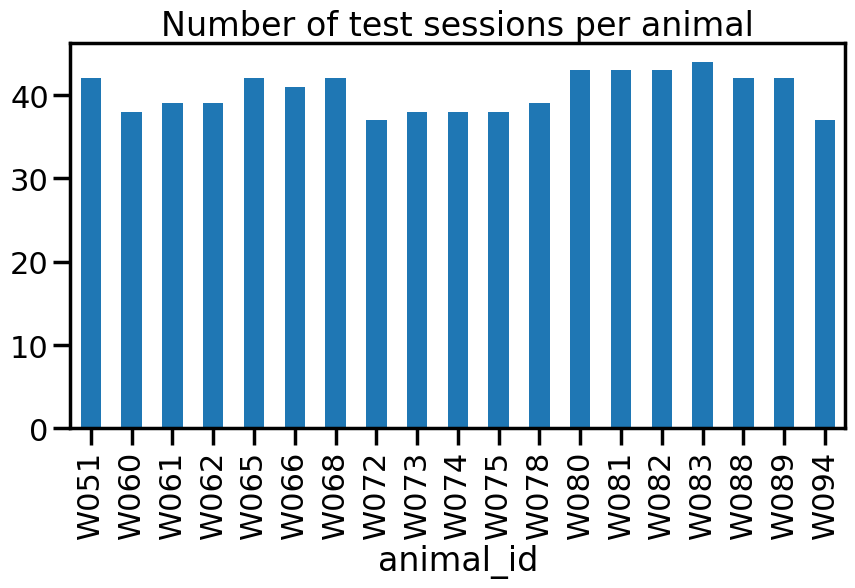

In [127]:
fig, ax = plt.subplots(figsize=(10, 5))
null_fits.groupby("animal_id")["num_test_sessions"].min().plot(kind="bar", ax=ax)

plt.title("Number of test sessions per animal")

Text(0.5, 1.0, 'Number of test trials per animal')

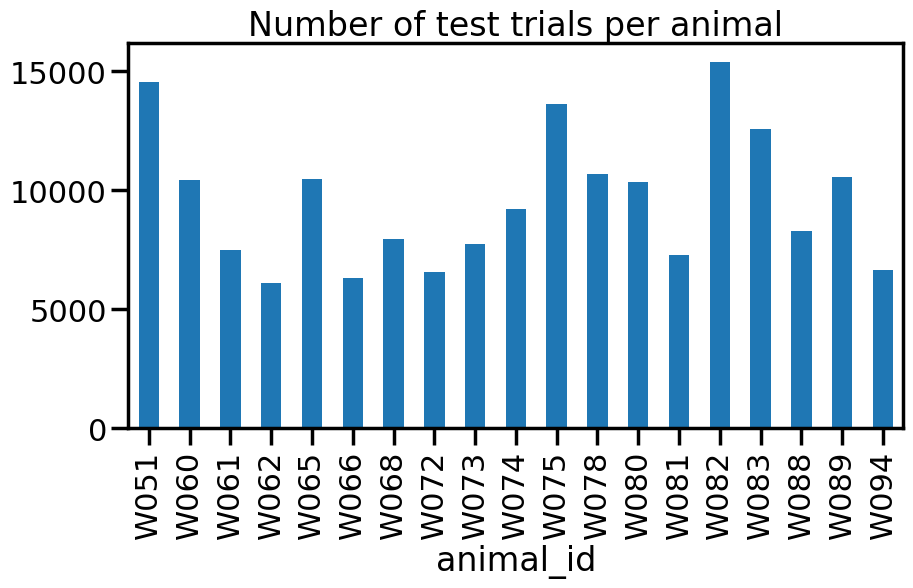

In [128]:
fig, ax = plt.subplots(figsize=(10, 5))
null_fits.groupby("animal_id")["n_test_trials"].min().plot(kind="bar", ax=ax)

plt.title("Number of test trials per animal")

In [118]:
experiment.null_fits.groupby("animal_id")["test_sessions"]